## Chapter 02. Multi Layer Perceptron

### MNIST MLP Prac

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.1.0+cu118  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. MNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.MNIST(root = "./data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor()) # 다운로드 받은 이미지를 tensor 형태로 변환 (transforms)

test_dataset = datasets.MNIST(root = "./data/MNIST",
                              train = False, # test set
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE, # 총 32개의 샘플이 하나의 배치로 묶여서 연산 (배치 단위로 샘플 호출)
                                           shuffle = True) # 훈련 데이터 셋은 호출 시 섞어줌 (대부분의 배치가 같은 클래스로 묶이지 않게끔) 

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 9912422/9912422 [00:01<00:00, 5175550.71it/s]


Extracting ./data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 19164007.88it/s]


Extracting ./data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3621348.17it/s]


Extracting ./data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw



In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type()) # 32, 1, 28, 28 float(실수) => 배치 사이즈(32 배치), 28 x 28 크기의 이미지, 채널은 1개
    print('y_train:', y_train.size(), 'type:', y_train.type()) # 한 배치에 해당하는 정답 숫자 32개
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


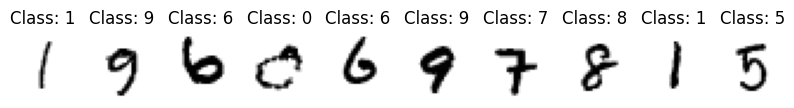

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 6. Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512) # 첫번째 레이어 : 이전 레이어(Input 레이어)의 노드 갯수 (28 * 28)와 현 레이어의 노드 개수(512) 정의
        self.fc2 = nn.Linear(512, 256) # 두번째 레이어
        self.fc3 = nn.Linear(256, 10) # 마지막 레이어
        # 총 3개의 fully-connected layer(nn.Linear)로 구성됨
        
    def forward(self, x): # x = 최초로 들어온 input tensor
        x = x.view(-1, 28 * 28) # x를 (batch_size, 28 * 28)의 모양으로 만들어줌
        x = self.fc1(x) # 생성자 함수에서 정의한 레이어 통과
        x = F.sigmoid(x) # sigmoid 활성함수 통과
        x = self.fc2(x) # 생성자 함수에서 정의한 레이어 통과
        x = F.sigmoid(x) # sigmoid 활성함수 통과
        x = self.fc3(x) # 생성자 함수에서 정의한 레이어 통과
        
        # 마지막으로 log_softmax 활성함수를 사용 -> softmax에 log를 취한 것과 동일
        # 두 연산을 따로 수행하는 것보다 더 빠름
        # 그냥 softmax에 의한 결과는 NLL Loss에 직접적으로 사용할 경우
        # 수치적으로 불안정해서 NaN의 결과를 얻을 수 있으므로, log_softmax와 NLL Loss를 결합하는 것을 추천
        x = F.log_softmax(x, dim = 1) # log
        return x

In [8]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE) # 정의한 네트워크를 DEVICE(GPU 혹은 CPU)에 올림
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5) # SGD with Momentum Optimizer 사용, 학습률 0.01, Momentum 0.5 (이전 스텝의 그래디언트 값에 곱해지는 factor)
# criterion = nn.CrossEntropyLoss() # CrossEntropyLoss에는 log softmax와 NLLloss가 포함되어 있음
criterion = nn.NLLLoss() # 따라서 위 처럼 log_softmax 사용했을 경우, NLLloss 사용, 마지막에 softmax 사용 안했으면 CrossEntropyLoss 사용

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader): # batch 는 image 와 label로 구성되어 있음
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() # gradient 0으로 초기화 = 이전 batch에서 계산한 gradient를 현 batch에서 사용하지 않을 것이기 때문
        output = model(image)
        loss = criterion(output, label)
        loss.backward() # requires_grad=True인 모든 parameter에 대해 gradient 계산
        optimizer.step() # update 진행

        if batch_idx % log_interval == 0: # 지정한 log_interval 마다 아래 문구 출력
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() # dropout 같은 train과 val/test 상황에서 상태가 달라지는 레이어를 위해 사용
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1] # dim = 1 을 따라서 maximum 값들을 구함
            correct += prediction.eq(label.view_as(prediction)).sum().item() # label을 prediction과 같은 Tensor shape를 갖도록 만들어준뒤 이를 prediction과 비교하여 같은 것만 추출(.eq). sum()을 통해 일치하는 것들의 개수를 받고, 이를 python 숫자로 반환(.item())
    # batch_size 가 하나의 tensor 내 샘플의 개수가 됨
    # 32개의 샘플 중 몇 개가 예측과 실제가 같았는지 계산
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset) # 맞은 갯수 / 총 테스트 데이터가 몇 장으로 구성되있는지
    return test_loss, test_accuracy

In [11]:
''' 10. MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200) # 200 step마다 결과 출력
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.414920
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.307064
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 2.318885
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 2.286137
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 2.294175
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 2.283427
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 2.252261
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 2.263627
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 2.252062
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 2.256709

[EPOCH: 1], 	Test Loss: 2.2343, 	Test Accuracy: 29.28 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 2.196687
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 2.242460
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 2.126732
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 2.219710
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 2.021261
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 1.830830
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 1.797855
T

### MLP With Dropout, ReLU, BN, HE, Adam

# 일반적인 딥러닝 모델의 학습 순서
1. 모델 구조를 설계하고 설계된 모델 구조의 파라미터(=Weight, Bias) 값을 랜덤으로 샘플링
2. 모델에 Input 데이터를 투입하고 Output을 계산
3. 계산된 Output을 Input 값과 매칭되는 정답 값과 비교하여 Loss 계산
4. 계산된 Loss를 통해 역전파(Back-propagation)을 수행하여 파라미터를 갱신
5. 2.~4. 과정을 반복하여 학습을 진행하며, 중간중간 Validation dataset으로 모델의 성능을 평가하여 평가 지표를 바탕으로 최적의 모델 선택
6. 5.에서 선택된 모델로 Test dataset의 성능 평가

In [12]:
''' Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5 # dropout 적용 레이어의 노드 중 50% (=0.5)에 dropout을 적용, activation 값을 0으로 만듬
        self.batch_norm1 = nn.BatchNorm1d(512) # 첫 fully-connected 레이어의 output 노드 수(=512)만큼 적용
        self.batch_norm2 = nn.BatchNorm1d(256) # 두번째 fully-connected 레이어의 output 노드 수(=256)만큼 적용

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob) # model.train() 혹은 model.eval()에 의해 self.training=True 혹은 self.training=False로 바뀜
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        # x = F.log_softmax(x, dim = 1) # 원본 파일에서는 softmax를 사용하는 것으로 되어있지만, nn.CrossEntropyLoss()의 내부에 log softmax + NLL loss가 포함되어 있기 때문에 제거
        return x

- 모델 구조의 파라미터 값을 랜덤으로 샘플링하는 과정에서 어떤 분포에서 샘플링을 진행하는지에 따라 모델 학습이 좋은 방향으로 시작될 수도, 나쁜 방향으로 시작될 수도 있음
  - ReLU 활성함수와 어울리는 `He initialization` 사용

In [13]:
''' Optimizer, Objective Function 설정하기 '''
import torch.nn.init as init # 초기화 관련 모듈인 init import
def weight_init(m):
    if isinstance(m, nn.Linear): # MLP 모델 중 nn.Linear에 해당하는 파라미터에 대해 초기화 수행
        init.kaiming_uniform_(m.weight.data) # He initialization (init.kaiming_uniform_ 이 He initialization 의미)

model = Net().to(DEVICE)
model.apply(weight_init) # Net()의 instance인 model에 He initialization 적용
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # Adam optimizer 사용, Learning rate=0.01 적용
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [14]:
''' MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [15]:
''' 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
''' MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 3.225241
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.478568
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.425489
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.287904
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.373578
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.475197
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.448329
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.095729
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.106933
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.208484

[EPOCH: 1], 	Test Loss: 0.0037, 	Test Accuracy: 96.42 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.258665
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.217964
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.074933
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.335782
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.197927
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.580512
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.171591
T

### MLP With CIFAR-10

- MNIST 데이터셋과 같은 방식으로, `torchvision`의 `datasets`로부터 CIFAR-10 데이터셋 다운로드
  - `root`: 데이터가 저장될 장소 경로 지정 `../`은 상위폴더 의미
  - `train`: training 데이터셋인지, test 데이터셋인지 설정(True면 training 데이터셋)
  - `download`: 인터넷에서 다운로드해 이용할 것인지 결정하는 요소
  - `transform`: 다운로드할 때 기본적인 전처리 동시에 진행할 수 있음, 여기서는 `transforms.ToTensor()`를 이용하였는데, Tensor 형태로 변환하고, pixel값을 255로 나누어 0~1 사이의 숫자로 정규화하는 과정이 포함되어 있음
    - `transforms.ToTensor()` :  `PIL` 이미지나, numpy.ndarray (H x W x C) in the range [0, 255] 형태로 표현된 이미지를 shape (C x H x W) in the range [0.0, 1.0]의 `torch.FloatTensor`으로 바꿔줌

- `DataLoader`: 다운로드한 dataset을 mini-batch 단위로 분리하여 불러오기 위한 loader
  `shuffle`: 데이터의 순서를 섞고자할 때

In [17]:
''' CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:39<00:00, 4271088.85it/s]


Extracting ./data/CIFAR_10\cifar-10-python.tar.gz to ./data/CIFAR_10


In [18]:
''' 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


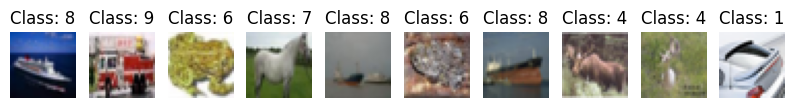

In [19]:
''' 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [20]:
''' Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.log_softmax(x, dim = 1)
        return x 

In [21]:
''' Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [22]:
''' MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [23]:
''' 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [24]:
''' MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.281679
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.953266
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.768429
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.942190
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.809869
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.903673
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.682141
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.818140

[EPOCH: 1], 	Test Loss: 0.0547, 	Test Accuracy: 36.03 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.660260
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.367717
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.708410
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.666535
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.603441
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.752793
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.553816
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.972110

[EPOCH: 2], 	Test Loss: 0.0501, 	Test Accuracy: 41.84 % 